In [17]:
from collections import Counter

import math
import re

from pandas import read_excel
from pymongo import MongoClient
from pyquery import PyQuery as pq
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
SHEETS = (
    ("神外-總院_1070920.xlsx", "總院"), 
#     ("(骨穩)總院_分科1070928.xlsx", "工作表1")
    ("(骨穩)總院_分科1071002.xlsx", "工作表1")
)

In [3]:
client = MongoClient("mongodb.xiao.tw", 27017)
db = client.forteo
posts = db.posts

In [4]:
from matplotlib.font_manager import FontManager

import subprocess

def get_matplot_zh_font():
    fm = FontManager()
    mat_fonts = set(f.name for f in fm.ttflist)

    output = subprocess.check_output('fc-list :lang=zh -f "%{family}\n"', shell=True)
    output=str(output)
    zh_fonts = set(f.split(',', 1)[0] for f in output.split('\n'))

    print(mat_fonts)
    print(zh_fonts)
    available = list(mat_fonts & zh_fonts)

    print ('*' * 10, '可用的字體', '*' * 10)
    for f in available:
        print(f)
    return available

def set_matplot_zh_font():
    available = get_matplot_zh_font()
    if len(available) > 0:
        mpl.rcParams['font.sans-serif'] = [available[0]]    # 指定默認字體
        mpl.rcParams['axes.unicode_minus'] = False          # 解決保存圖像是負號'-'顯示為方塊的問題
        
# set_matplot_zh_font()



In [5]:
frames = []

In [6]:
for file_name, sheet_name in SHEETS:
    data = read_excel(file_name, sheet_name)
    frames.append(data)

In [7]:
df=pd.concat(frames, ignore_index=True, sort=False)
df.to_excel('concat.xls')

In [21]:
print(df['用藥時間'].mean())
print(df['用藥時間'].median(), df['用藥時間'].min(), df['用藥時間'].max())

8.680568609022558
6.696428571428571 0.14285714285714285 24.0


In [22]:
antiresorptives = {
    'Prolia': 'RANKL inhibitor',
    'Evista': 'SERM',
    'Fosamax': 'Bisphosphonate',
    'Aclasta': 'Bisphosphonate',
}

In [39]:
countDrug = Counter()

column_ar = []

for index, row in df.iterrows():
    tmp_ar = None
    post = posts.find_one({"_id": row['病歷號']})
    if post is None:
        continue
        print(index, row['病歷號'], post)

#     print(index, row['病歷號'])
    drug_set = set()
    if post['drug']:
        
        for drugs in post['drug']:
#             print(drugs)
            for tr in drugs['Drug']:
                pqtr = pq(tr)
                drugname = pqtr('td')[0].text
                drugname = drugname.replace('(管4) ', '')
                drug_set.add(drugname)
#                 countDrug[pqtr('td')[0].text] += 1
#                 print(pqtr('td')[0].text)
#                 break
#         print(drug_set)
                if tmp_ar is None:
                    for ar in antiresorptives:
                        if drugname.startswith(ar):
                            tmp_ar = ar

        for d in drug_set:
            countDrug[d] += 1
    
    column_ar.append(tmp_ar)
#         break
# print(countDrug)
#     row['AR'] = column_ar
    df.loc[index, 'AR'] = tmp_ar
    if tmp_ar:
        df.loc[index, 'AR2'] = antiresorptives[tmp_ar]
        df.loc[index, 'antiresorptives'] = tmp_ar if tmp_ar == 'Prolia' else ' Others'



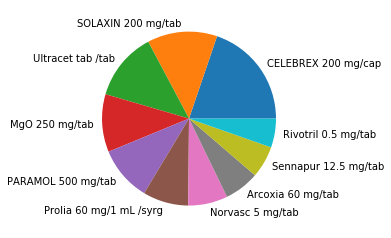

In [27]:
cDrug = countDrug
del cDrug['Forteo Prefilled Inj 600 mcg/2.4 mL /pen']
del cDrug['(4mm) Micro-Fine Insulin Pen Needle 32G /set']
del cDrug['(8mm) Micro-Fine Insulin Pen Needle 31G /set']
labels, values = zip(*countDrug.most_common(10))
# plt.rcParams['font.sans-serif']=['Arial Unicode MS'] #用来正常显示中文标签
plt.pie(values, labels=labels)
plt.savefig('drug.png', dpi=400)

In [28]:
antiresorptives = {
    'Prolia': 'RANKL inhibitor',
    'Evista': 'SERM',
    'Fosamax': 'Bisphosphonate',
    'Aclasta': 'Bisphosphonate',
}

Counter({'Prolia': 30, 'Evista': 10, 'Fosamax': 6, 'Aclasta': 5})
Counter({'RANKL inhibitor': 30, 'Bisphosphonate': 11, 'SERM': 10})


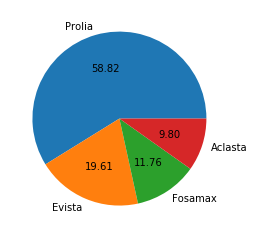

In [29]:
cAR = Counter()
ccAR = Counter()

for c in countDrug:
    for ar in antiresorptives:
        if c.startswith(ar):
            cAR[ar]+=countDrug[c]
            ccAR[antiresorptives[ar]]+=countDrug[c]
            
print(cAR)
print(ccAR)
labels, values = zip(*cAR.most_common())
plt.pie(values, labels=labels, autopct='%.2f')
plt.savefig('cAR.png', dpi=400)

In [30]:
PATTERNS = (
    'T-\s*score\s*=\s*([-+]?\d*\.\d+)',
    'T-\s*score\s*=\s*(- \d*\.\d+)',
    'T-score is\s*([-+]?\d*\.\d+)',
    'T score =\s*([-+]?\d*\.\d+)',
)
def T_score(html):
    min = None
    for pattern in PATTERNS:
        for m in re.findall(pattern, html):
#             print(m)
            t = float(m.replace(' ', ''))
#             print (t)
            if min and t > min:
                continue
            min = t            
    return min 


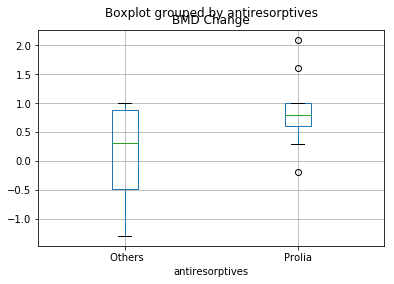

In [43]:
PRE = []
POST =[]

for index, row in df.iterrows():
    post = posts.find_one({"_id": row['病歷號']})
    if post is None:
        continue
        print(index, row['病歷號'], post)

#     print(index, row['病歷號'])
#     print(post)
    if post['report']:
        BMD = {}
        for r in post['report']:
#             print(r)

            r_class = r['報告類別'].upper()
            r_date  = r['檢查日期']
            if 'BMD' in r_class:
#                 print(r_date, r_class)
#                 print(r)
#                 print(row['病歷號'], r_date, r_class)
                t_score = T_score(r['html'])
                if t_score is None:
#                     # No T score in report
#                     print(row['病歷號'], r_date, t_score, r_class)
                    continue
    
                if r_date not in BMD or t_score < BMD[r_date]:
                    BMD[r_date] = t_score
                
#         print(row['簽署日'], row['流失/停藥日期'])
#         print(type(row['簽署日']), type(row['流失/停藥日期']))
        
        if type(row['簽署日']) is not str and math.isnan(row['簽署日']):
            dStart = row['流失/停藥日期']
        else:
            dStart = row['簽署日']
        if BMD:        
#             print(row['病歷號'], dStart, BMD)
            
            pre = None
            post = None
            
            for d, b in BMD.items():
                if d > dStart:
                    post = b
                else:
                    pre = b
                    
            if pre and post:
                PRE.append(pre)
                POST.append(post)
#                 print(row['病歷號'], dStart, pre, post)
                df.loc[index, 'BMD Change'] = post-pre

df.to_excel('concat3.xls')
    
D=df.boxplot(column='BMD Change',by='antiresorptives')    
D.get_figure().savefig('cAR3.png', dpi=400)


In [ ]:
d = {
    'bmd_before': PRE, 
    'bmd_after': POST,
}

df2 = pd.DataFrame(data=d)
df2.describe()        
df2.plot(kind='box')        
# plt.savefig('boxplot_outliers.png')
                
# print(stats.ttest_rel(df2['bmd_before'], df2['bmd_after']))
